In [9]:
from zentools.data_operations import slice_dataframe_by_date, add_macd, add_ewm_rsi, add_rsi
import pandas as pd
import numpy as np

In [10]:
# Load the CSV without the deprecated 'date_parser'
data = pd.read_csv("/home/bobo/Documents/Datasets/Binance_ETHUSDT_1h .csv", parse_dates=["Date"], index_col="Date")

# Convert the index to datetime manually (to ensure proper handling of any date format)
data.index = pd.to_datetime(data.index, format='ISO8601')

# Sort the DataFrame by index
data = data.sort_index()

In [11]:
add_macd(data, 12, 26, 9)
add_rsi(data)
data['Close'] = data['Close'].pct_change()
data['Volume ETH'] = data['Volume ETH'].pct_change()
data['EMA_12'] = data['EMA_12'].pct_change()
data['EMA_26'] = data['EMA_26'].pct_change()
data['tradecount'] = data['tradecount'].pct_change()
# clip
data['Close'] = data['Close'].clip(-1, 1)
data['Volume ETH'] = data['Volume ETH'].clip(-1, 1)
data['EMA_12'] = data['EMA_12'].clip(-1, 1)
data['EMA_26'] = data['EMA_26'].clip(-1, 1)
data['tradecount'] = data['tradecount'].clip(-1, 1)
# Replace +inf and -inf with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.fillna(0)
data.head()

,Symbol,Open,High,Low,Close,Volume ETH,Volume USDT,tradecount,EMA_12,EMA_26,MACD,Signal_Line,Histogram,RSI
Date,,,,,,,,,,,,,,
2017-08-17 04:00:00,ETHUSDT,301.13,302.57,298.0,0.000000,0.000000,37684.804181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2017-08-17 05:00:00,ETHUSDT,301.61,303.28,300.0,0.004940,1.000000,114043.282676,0.565891,0.000760,0.000366,0.118860,0.023772,0.095088,0.0
2017-08-17 06:00:00,ETHUSDT,302.40,304.44,301.9,-0.001386,-0.195423,92034.441294,-0.099010,0.000429,0.000236,0.177126,0.054443,0.122683,0.0
2017-08-17 07:00:00,ETHUSDT,302.68,307.96,302.6,0.017444,1.000000,229725.136967,0.087912,0.003052,0.001514,0.641953,0.171945,0.470008,0.0
2017-08-17 08:00:00,ETHUSDT,307.95,309.97,307.0,0.002143,-0.800263,46559.462371,-0.080808,0.002910,0.001562,1.051468,0.347850,0.703619,0.0


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# Assuming Date is already the index, only select the relevant features (excluding Date)
features = ['Open','High','Low','Close', 'Volume ETH','Volume USDT', 'tradecount','EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'Histogram','RSI']

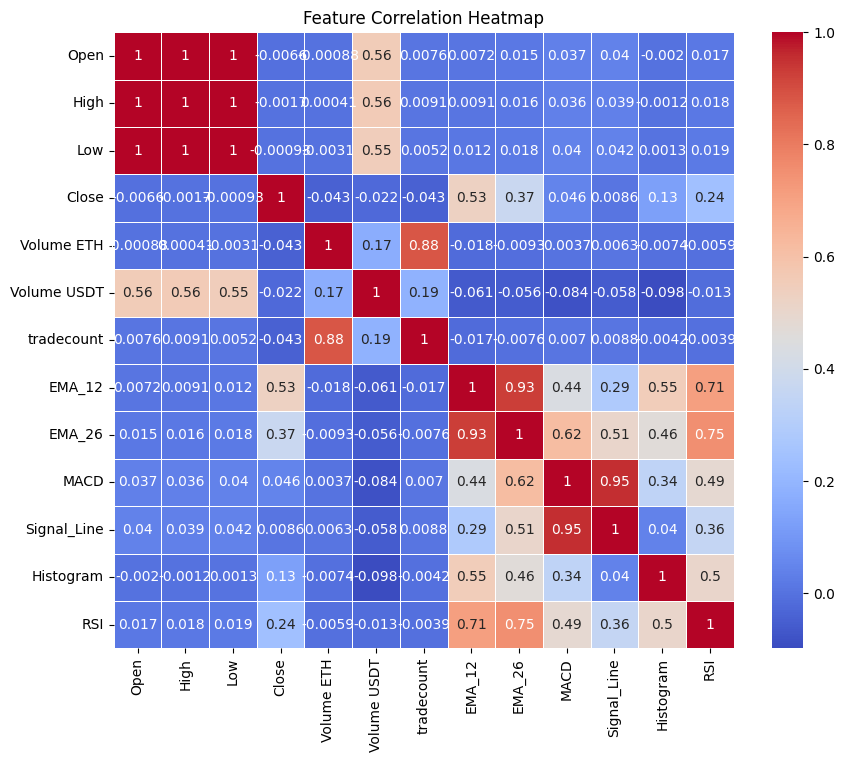

In [14]:
# Compute correlation matrix
correlation_matrix = data[features].corr()
# Visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
# Select features with correlation < 0.8
threshold = 0.8
high_corr_features = np.where(np.abs(correlation_matrix) > threshold)
high_corr_features = [(correlation_matrix.columns[x], correlation_matrix.columns[y]) 
                      for x, y in zip(*high_corr_features) if x != y and x < y]

In [16]:
high_corr_features

[('Open', 'High'),
 ('Open', 'Low'),
 ('High', 'Low'),
 ('Volume ETH', 'tradecount'),
 ('EMA_12', 'EMA_26'),
 ('MACD', 'Signal_Line')]

In [18]:
# Remove highly correlated features
features_to_drop = [col for pair in high_corr_features for col in pair[1:]]
reduced_features = [f for f in data.columns if f not in features_to_drop]
data_reduced = data[reduced_features]

Text(0.5, 1.0, 'Feature Correlation Heatmap')

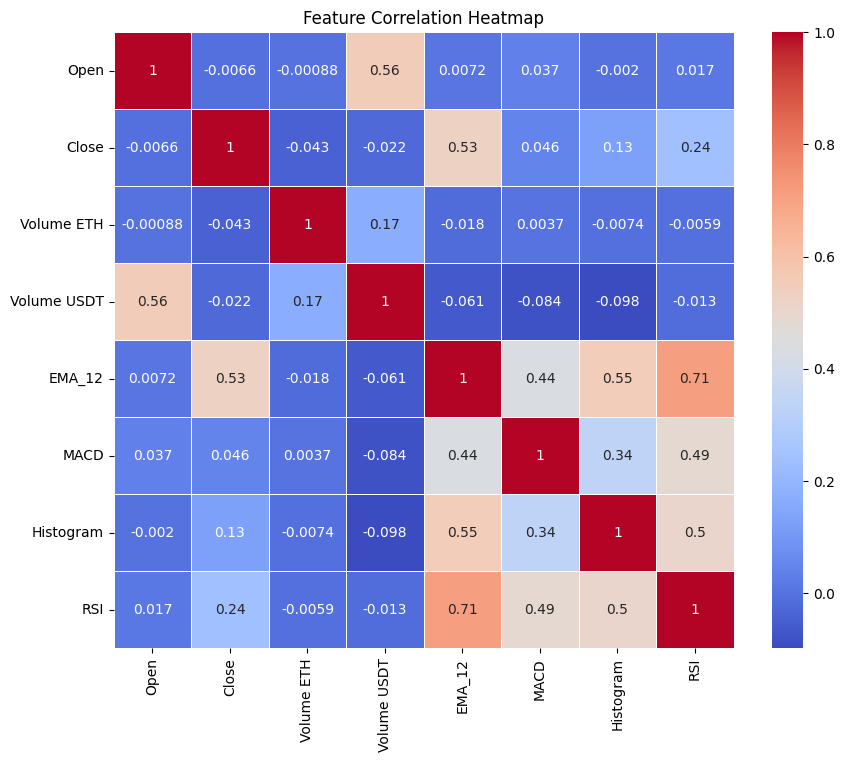

In [23]:
data_reduced = data_reduced.drop(columns=['Symbol'])
data_reduced.set_index('Close')
correlation_matrix = data_reduced.corr()
# Visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')

In [231]:
# Assuming Date is already the index, only select the relevant features (excluding Date)
features = ['Close', 'Volume ETH', 'tradecount','EMA_12', 'EMA_26', 'MACD', 'RSI']
X = data[features]  # Only select the columns, not the index
y = data['Close']  # Assuming your target column is 'target'

In [307]:
# Split into training and testing sets
# Remove rows with NaN values in the target variable
X_cleaned = X[~y.isna()]
y_cleaned = y.dropna()

# Ensure X and y have the same length
assert len(X_cleaned) == len(y_cleaned)

# Now you can split and train your model
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.75, random_state=42)

In [308]:
# Define the pipeline
pipe = Pipeline([
    ("scale", MinMaxScaler()),  # Feature scaling
    ("model", RandomForestRegressor(random_state=42))  # Random Forest Regressor for continuous target
])

In [309]:
param_grid = {
    'model__n_estimators': [100, 200],  # Number of trees
    'model__max_depth': [None, 10, 20],  # Maximum depth of the trees
    'model__min_samples_split': [2, 5],  # Minimum samples to split an internal node
    'model__min_samples_leaf': [1, 2],  # Minimum samples in the leaf nodes
    'model__max_features': ['sqrt', 'log2']  # Max features options
}

In [310]:
# Set up GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=2)

In [311]:
# Fit the model
# grid_search.fit(X_train, y_train)

In [312]:
# Output the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Evaluate on test set
print("Test set score: ", grid_search.score(X_test, y_test))

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [313]:
# Define the model and the optimal hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=4,
    n_jobs=-1,  # To use all processors during training
    random_state=42
)
from sklearn.neural_network import MLPRegressor
# Create the pipeline
pipe = Pipeline([
    ('scaler', MinMaxScaler()),  # Standardize features
    ('model', MLPRegressor())  # RandomForestClassifier with optimal hyperparameters
])

In [314]:
# Fit the model on the training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', MLPRegressor())])

In [315]:
y_pred = pipe.predict(X_test)

In [316]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Actual vs Predicted Returns')

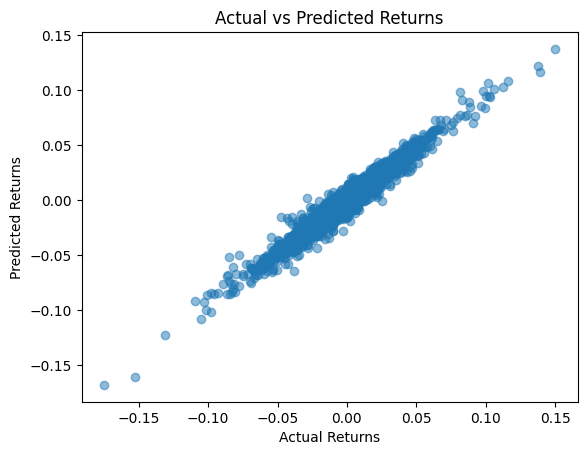

In [317]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Actual vs Predicted Returns")

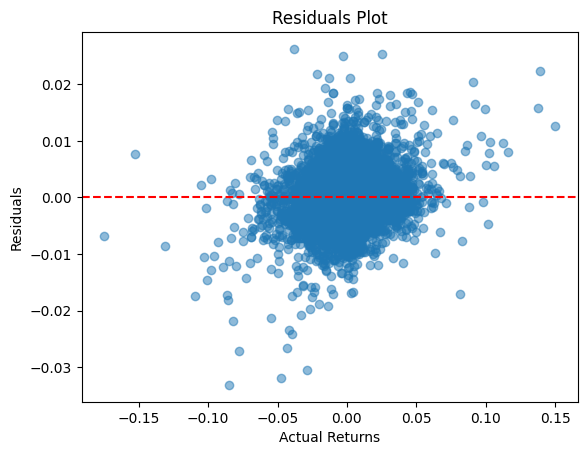

In [318]:
# Calculate residuals
residuals = y_test - y_pred

# Scatter plot of residuals
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Returns")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

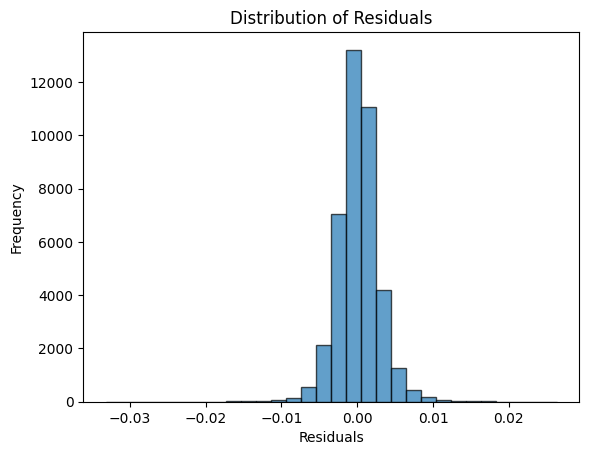

In [319]:
# Histogram of residuals
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

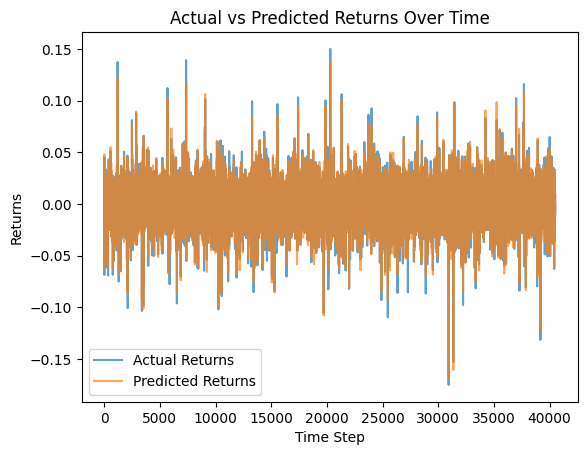

In [320]:
# Line plot for actual and predicted values
plt.plot(y_test.reset_index(drop=True), label="Actual Returns", alpha=0.7)
plt.plot(y_pred, label="Predicted Returns", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Returns")
plt.title("Actual vs Predicted Returns Over Time")
plt.legend()
plt.show()